This notebook tests flowlines drawn manually using the linear interpolation of surface velocities
from GPS data and the map of possible old ice derived from driving stress (bed slope and surface slope) 
discontinuities.

## 0. Import packages

In [131]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager, functionspace
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob
from scripts.AH_temp_funcs import *
import rasterio
from rasterio.plot import show
import shapefile as shp
from pyproj import Transformer
from firedrake import *
from matplotlib.collections import LineCollection
%matplotlib widget

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## 1. Load the meshes

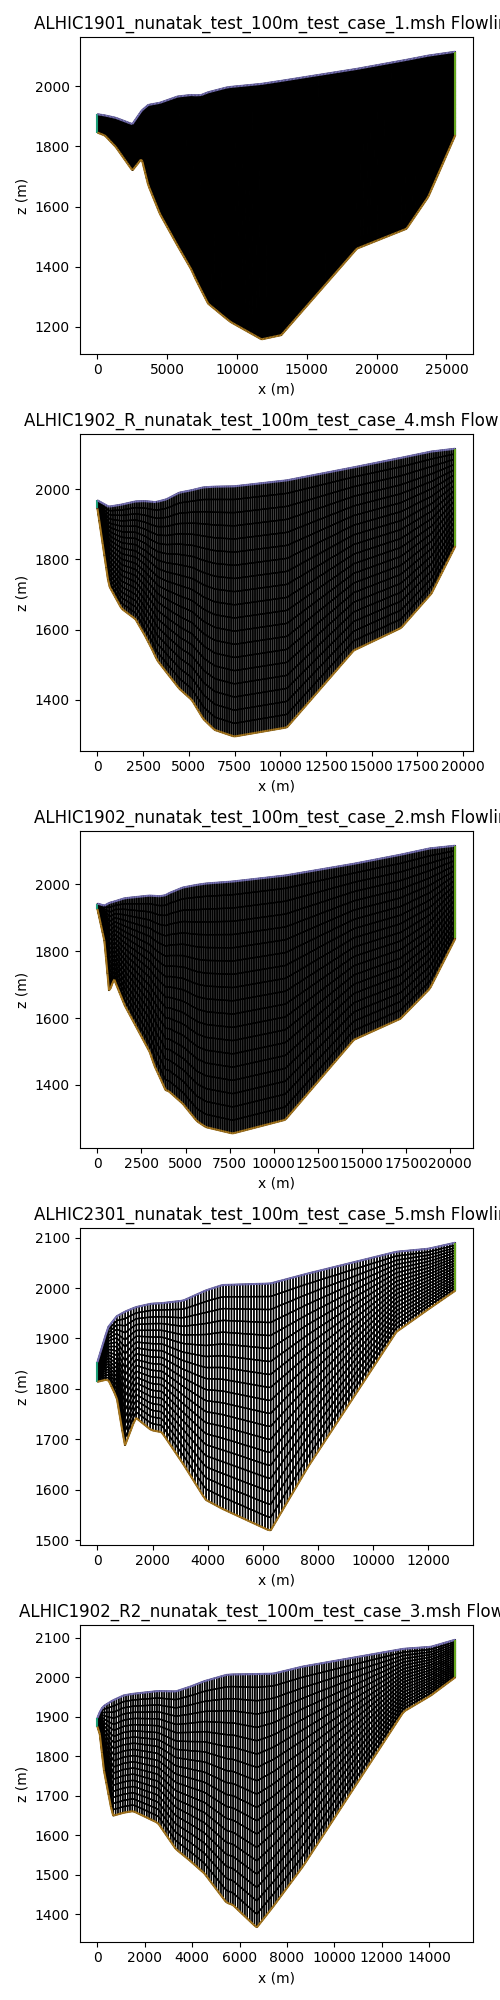

In [2]:
bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

meshes = []

fig,axes = plt.subplots(len(glob.glob('../Meshes/old_ice_meshes/*')), 1, figsize = (5,20))

for num,mesh in enumerate(glob.glob('../Meshes/old_ice_meshes/*')):

    borehole_name = mesh[25:]
    mesh = Mesh(mesh)

    

    meshes.append(mesh)
    

    axes[num].set_aspect("auto")
    axes[num].set_xlabel("x (m)")
    axes[num].set_ylabel("z (m)")
    firedrake.triplot(mesh, axes=axes[num])
    axes[num].set_title(borehole_name + ' Flowline')

plt.tight_layout()
plt.show()

## 2. Load imagery and old ice location raster and the borehole locations

In [90]:
with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

with rasterio.open('old_ice_loc.tif') as src_old_ice:
    old_ice_loc_data = src_old_ice.read()

sf = shp.Reader("../Borehole_Locations/AH_core_locations_reproj.shp")

bor_shapes = sf.shapes()
bor_records = sf.records()

## 3. Model the temp profile

This is just a dummy variable at this point really

In [3]:
climate_model = np.linspace(-34,-34,20)

## 4. Get the flowlines for each test case

In [91]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")

sf2 = shp.Reader("../flowlines/old_ice_flowlines/test_flowlines_1902nunatak.shp")

man_shapes = sf2.shapes()
man_records = sf2.records()

flowlines = {}

for n, (shape, record) in enumerate(zip(man_shapes,man_records)):
    points = shape.points
    x, y = zip(*points)
    flow_points = np.array((x,y)).T
    flow_points = np.array([transformer.transform(i[1], i[0]) for i in flow_points])
    x, y = flow_points[:,0], flow_points[:,1]
    name = record[1]
    flowlines['test_case_'+str(name)] = list([x,y])

## 5. Calculate the stokes flow for each flowline

In [40]:
velocity_fields = {}

for mesh, name in zip(meshes, glob.glob('../Meshes/old_ice_meshes/*')):

    borehole_name = name[-15:-4]
    print(borehole_name)
    x, z, ϕ, T, y, u, V, bcs_temp = initial_conditions(mesh, climate_model)

    T,y, stokes_solver = viscosity_updater(x, z, ϕ, T, y, u, V, bcs_temp, mesh)

    velocity_fields[borehole_name] = y
    # fig, axes = plt.subplots(figsize = [10,5])
    # vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno", scale=1);
    # fig.colorbar(vel_field_plot, label='velocity (m/yr)')
    # axes.set_ylabel('Height (m)')
    # axes.set_xlabel('Distance (m)')
    # axes.set_title('Initial Stokes Solve')
    # plt.show()
    # x_vel = y.sub(0).sub(0).function_space()
    # x_vel = Function(x_vel).assign(y.sub(0).sub(0) * spy)

    # y_vel = y.sub(0).sub(1).function_space()
    # y_vel = Function(x_vel).assign(y.sub(0).sub(1) * spy)

    # fig, axes = plt.subplots(1, 3, figsize = [15,5])

    # vel_field_plot_x = firedrake.tricontourf(x_vel, axes=axes[0], cmap="seismic", vmin=-0.1, vmax=0.1)
    # fig.colorbar(vel_field_plot_x, label='velocity (m/yr)')

    # vel_field_plot_z = firedrake.tricontourf(y_vel, axes=axes[1], cmap="seismic", vmin=-0.1, vmax=0.1)
    # fig.colorbar(vel_field_plot_z, label='velocity (m/yr)')


    # axes[0].set_ylabel('Height (m)')
    # axes[0].set_xlabel('Distance (m)')
    # axes[0].set_title(borehole_name + ' Horizontal Velocity')

    # axes[1].set_ylabel('Height (m)')
    # axes[1].set_xlabel('Distance (m)')
    # axes[1].set_title(borehole_name + ' Vertical Velocity')

    # ## LIMA basemap image
    # show(image_data, transform=src1.transform, ax=axes[2])

    # plt.tight_layout()
    # plt.show()

test_case_1
0.08649772375471135
0.07324962201345718
0.054882885562994144
0.03930828264654934
0.027061914460014012
0.018182940515156183
0.012021763256776521
0.007866212613993315
test_case_4
0.03288069599087398
0.019663769376272105
0.016546886859650223
0.012428041122156744
0.00881886466545982
test_case_2
0.053477683068994884
0.03898831697591141
0.02848007177946862
0.020221155127276194
0.01408599697168141
0.009648205636865215
test_case_5
0.005419849351904104
test_case_3
0.014816575330644524
0.008522822922877803


## 6. Plot

test_case_1
test_case_4
test_case_2
test_case_5
test_case_3


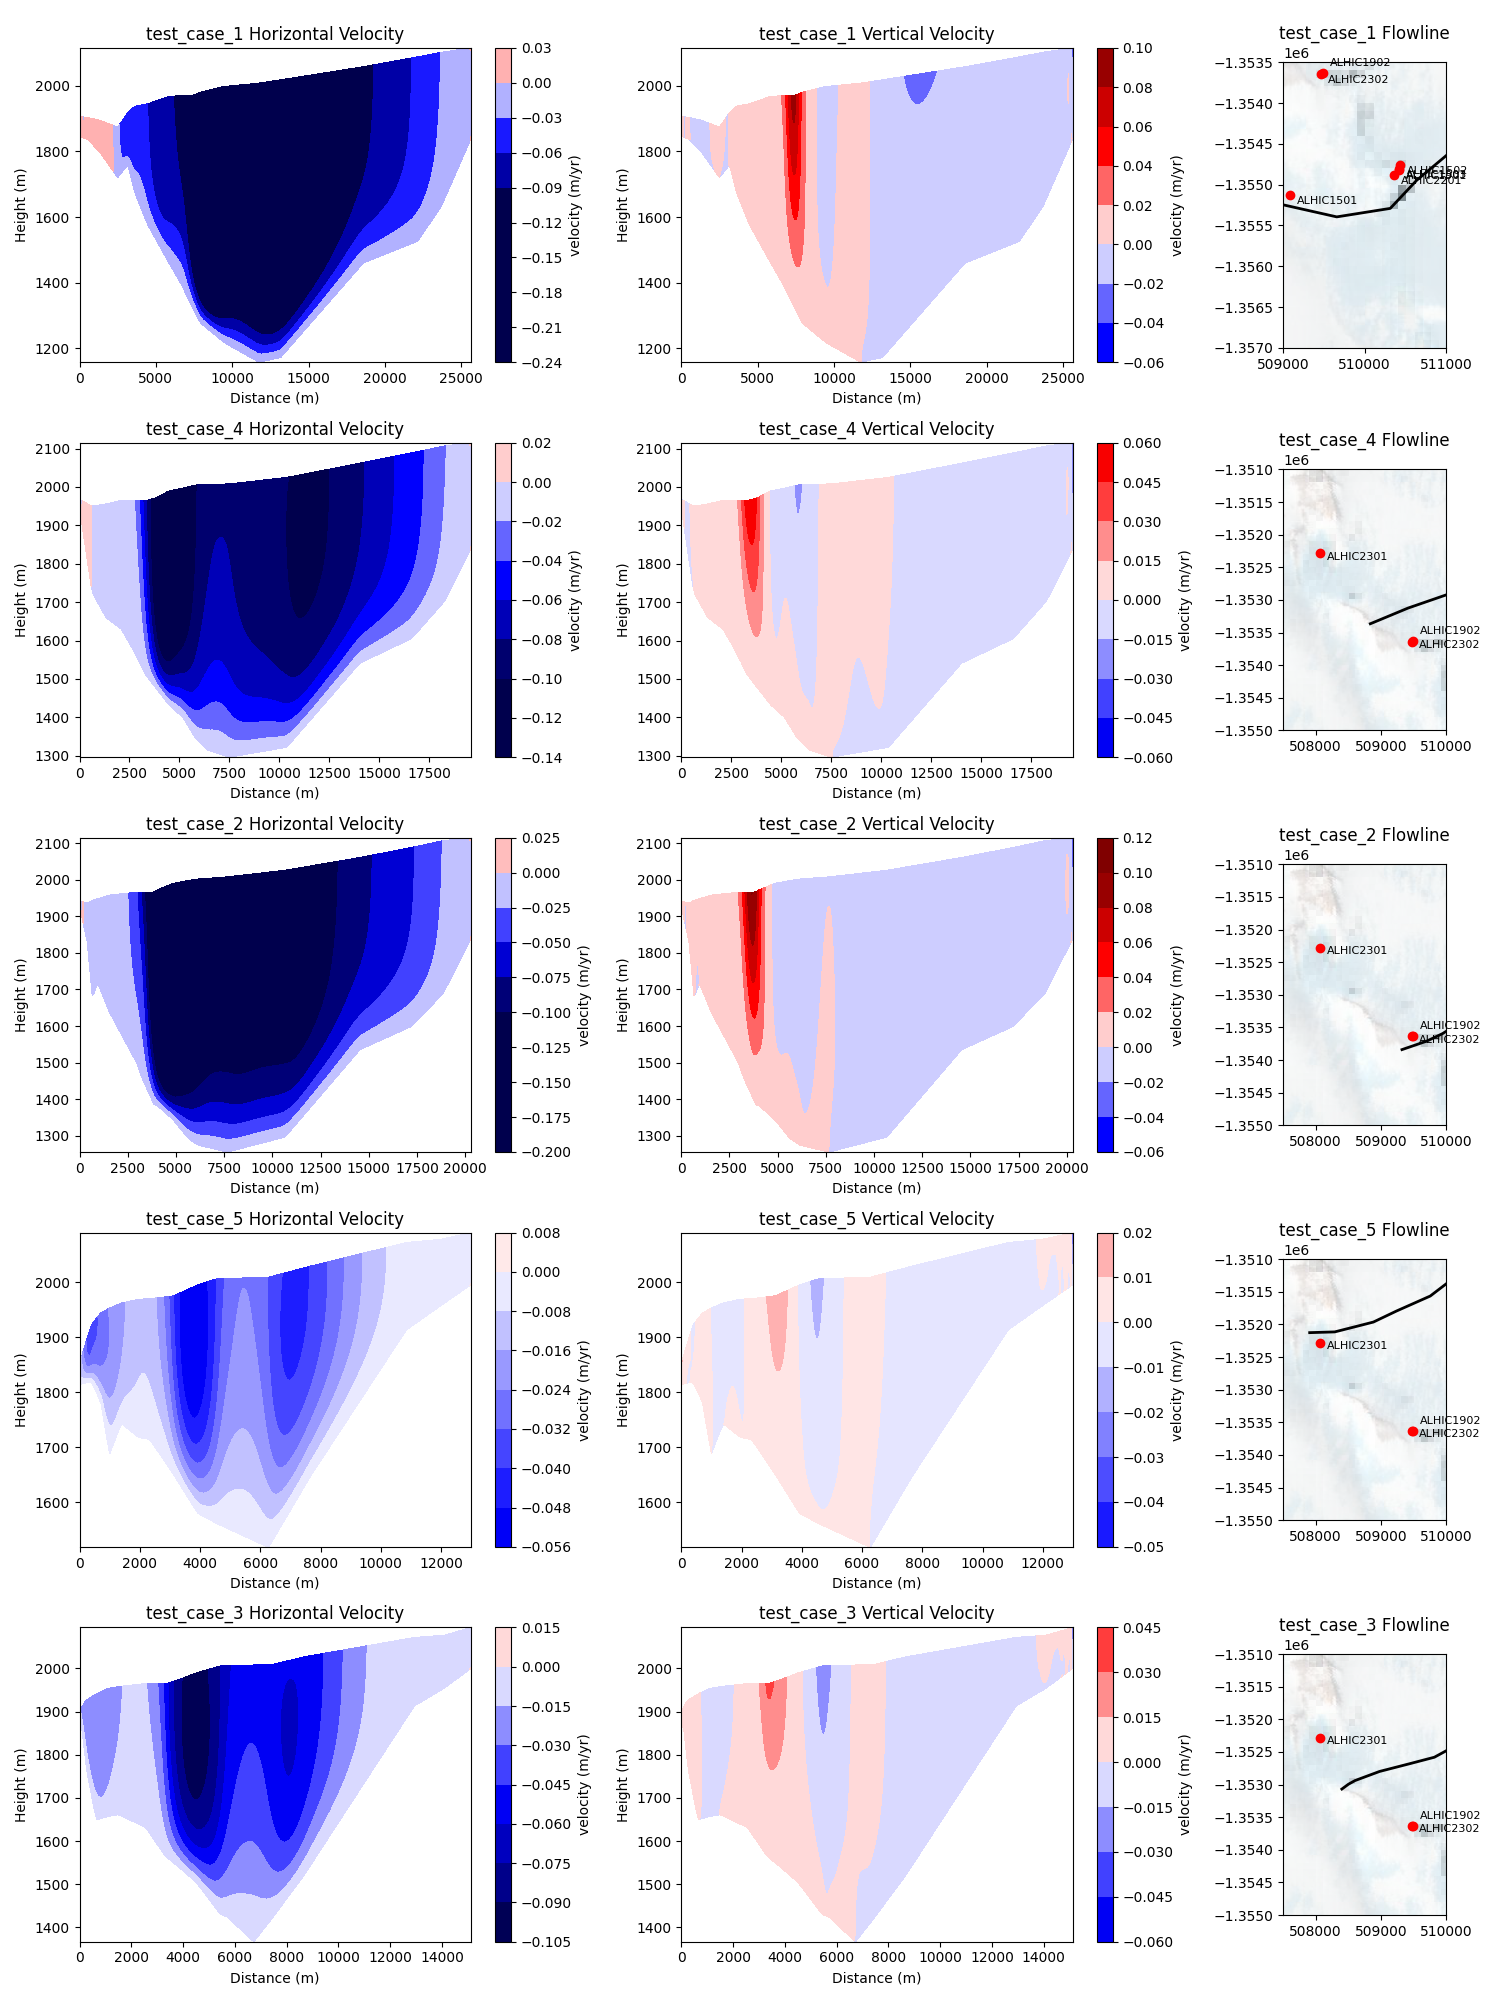

In [100]:
fig, axes = plt.subplots(len(velocity_fields), 3, figsize = [15,20], width_ratios=[3, 3, 1])

for i, ax in zip(velocity_fields, axes):
    

    y = velocity_fields[i]
    x_vel = y.sub(0).sub(0).function_space()
    x_vel = Function(x_vel).assign(y.sub(0).sub(0) * spy)

    y_vel = y.sub(0).sub(1).function_space()
    y_vel = Function(x_vel).assign(y.sub(0).sub(1) * spy)

    vel_field_plot_x = firedrake.tricontourf(x_vel, axes=ax[0], cmap="seismic", vmin=-0.1, vmax=0.1)
    fig.colorbar(vel_field_plot_x, label='velocity (m/yr)')

    vel_field_plot_z = firedrake.tricontourf(y_vel, axes=ax[1], cmap="seismic", vmin=-0.1, vmax=0.1)
    fig.colorbar(vel_field_plot_z, label='velocity (m/yr)')


    ax[0].set_ylabel('Height (m)')
    ax[0].set_xlabel('Distance (m)')
    ax[0].set_title(i + ' Horizontal Velocity')

    ax[1].set_ylabel('Height (m)')
    ax[1].set_xlabel('Distance (m)')
    ax[1].set_title(i + ' Vertical Velocity')

    ## LIMA basemap image
    show(image_data, transform=src1.transform, ax=ax[2])
    show(old_ice_loc_data, transform=src_old_ice.transform, ax=ax[2], alpha = 0.8, cmap="Greys")

    ax[2].plot(flowlines[i][0], flowlines[i][1], color='black', linewidth=2)
    ax[2].set_title(i + ' Flowline')

    ## Borehole locations
    for shape, record in zip(bor_shapes,bor_records):
        points = shape.points
        x, y = zip(*points)

        ax[2].plot(x, y, 'o',color='red', markersize=6)
        if record[0] == 'ALHIC1902':
            ax[2].annotate(record[0], xy=(x[0], y[0]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
        else:
            ax[2].annotate(record[0], xy=(x[0], y[0]-200), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
    if i == 'test_case_1':
        ax[2].set_xlim([509000, 511000])
        ax[2].set_ylim([-1.357e6, -1.3535e6])
    else:
        ax[2].set_xlim([507500, 510000])
        ax[2].set_ylim([-1.355e6, -1.351e6])
    print(i)
plt.tight_layout()
plt.savefig('old_ice_flowlines_velocity_profiles.png', dpi=300)



## 7. Calculate the convergence rate

In [ ]:


convergence_maps = {}

for i in velocity_fields:
    y = velocity_fields[i]
    # Create a scalar FunctionSpace for convergence
    Q = FunctionSpace(y.sub(0).function_space().mesh(), "CG", 1)

    # Interpolate the convergence (−div y)
    vel_convergence = Function(Q).interpolate(-div(y.sub(0))*spy)

    convergence_maps[i] = vel_convergence

#### 7.1 Plot the convergence rate

test_case_1
test_case_4
test_case_2
test_case_5
test_case_3


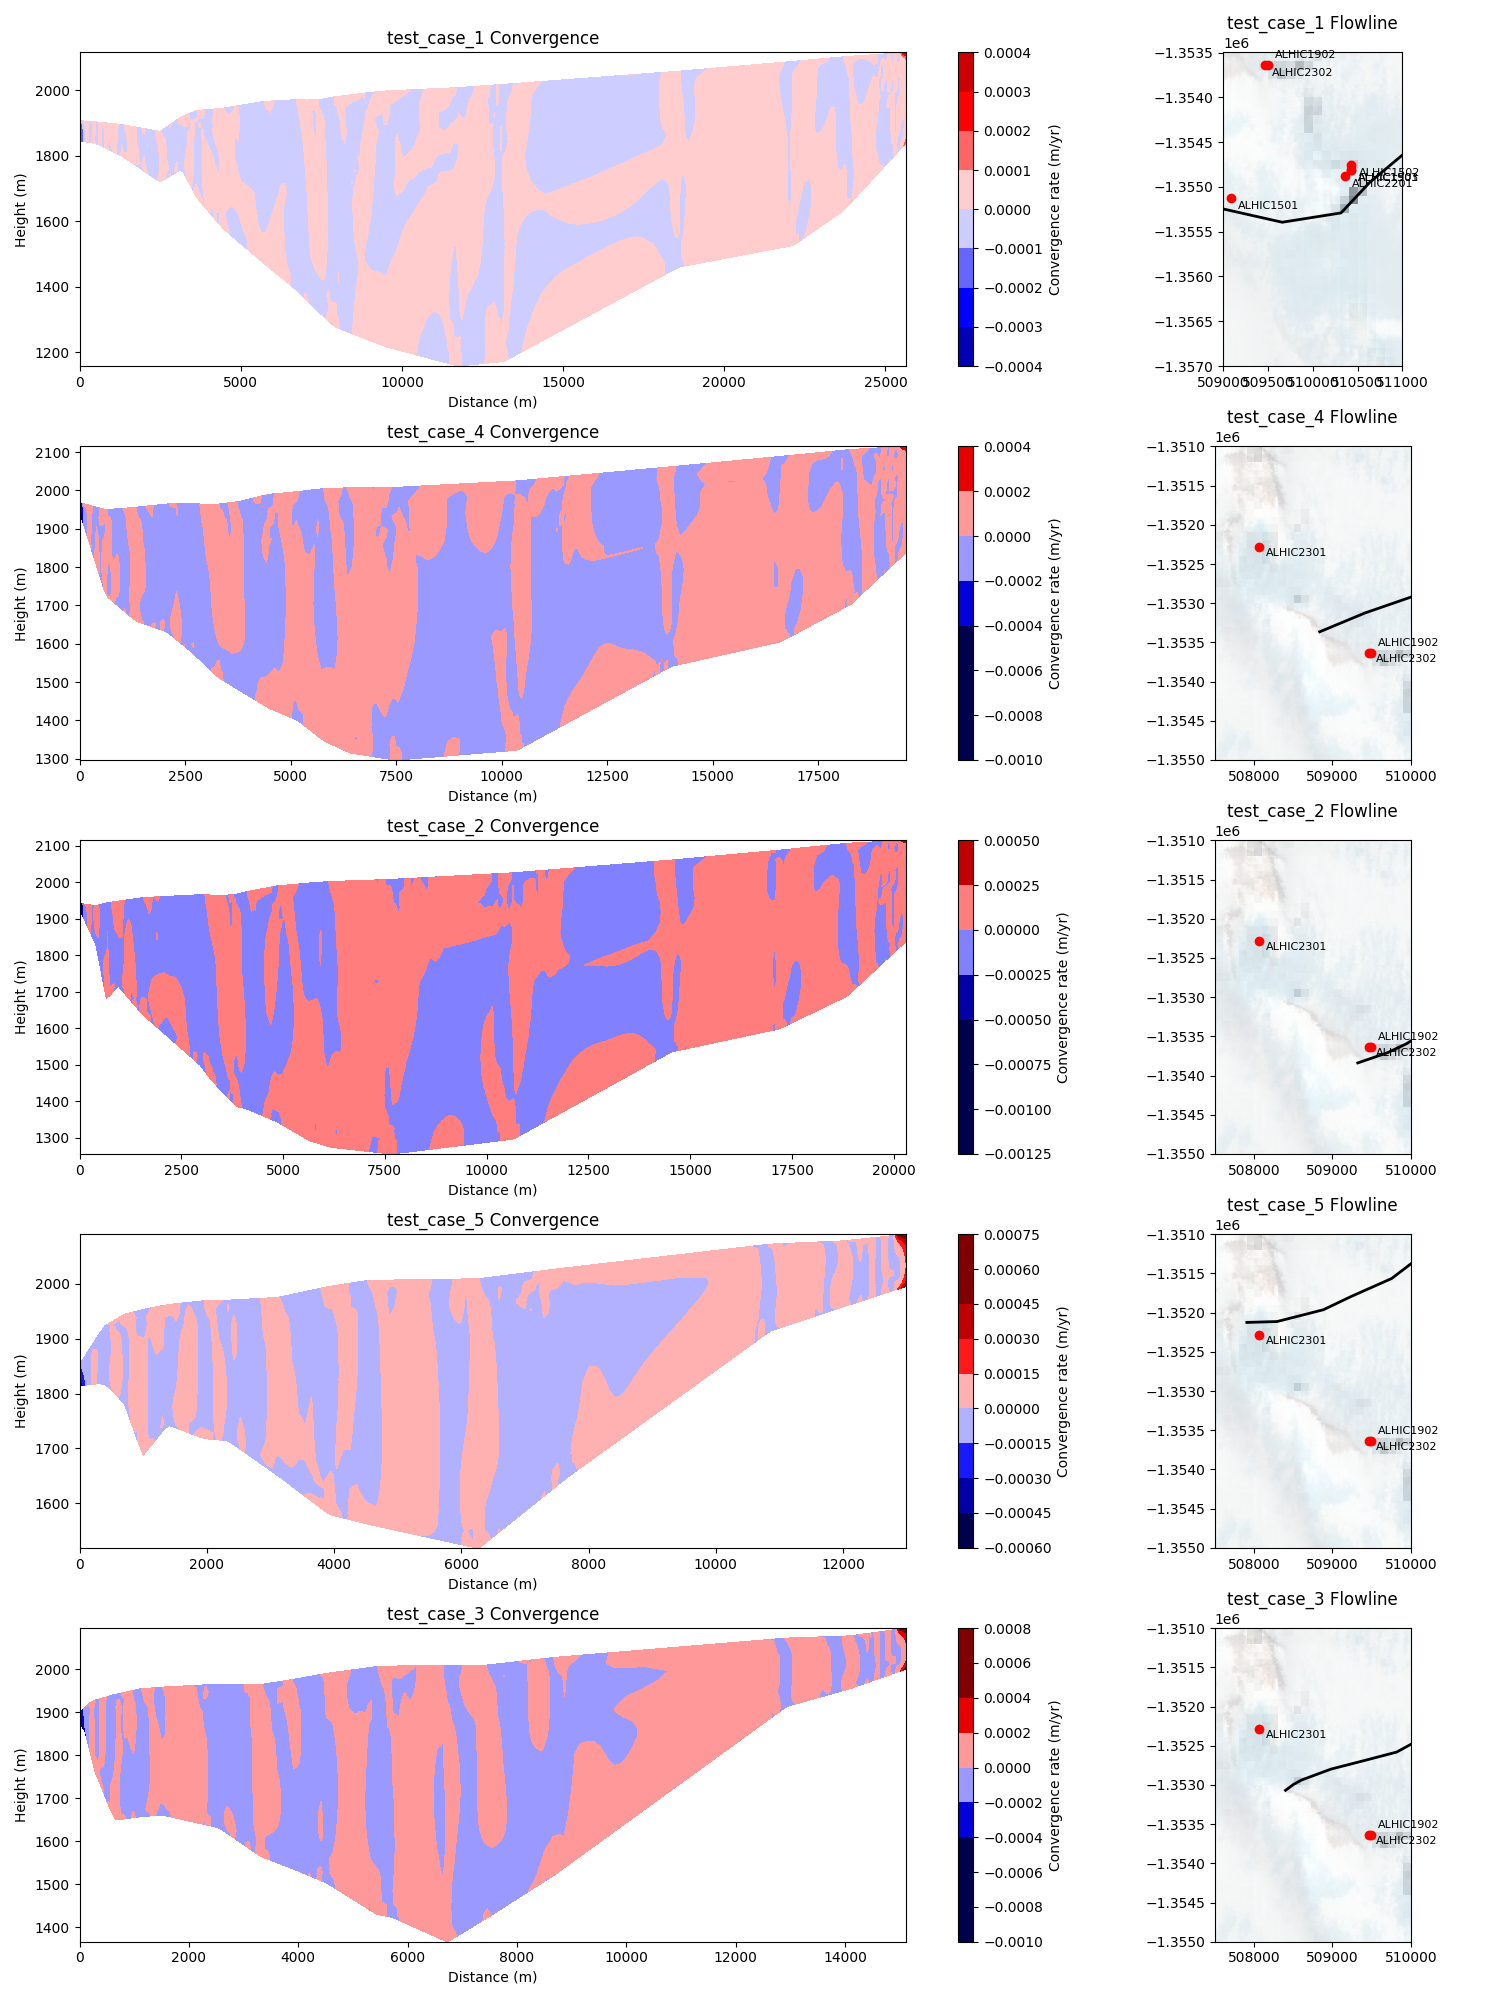

In [102]:
fig, axes = plt.subplots(len(convergence_maps), 2, figsize = [15,20], width_ratios=[3, 1])

for i, ax in zip(convergence_maps, axes):
    

    convergence = convergence_maps[i]

    convergence_plot = firedrake.tricontourf(convergence, axes=ax[0], cmap="seismic", vmin = -5e-4, vmax = 5e-4)
    fig.colorbar(convergence_plot, label='Convergence rate (m/yr)')


    ax[0].set_ylabel('Height (m)')
    ax[0].set_xlabel('Distance (m)')
    ax[0].set_title(i + ' Convergence')



    ## LIMA basemap image
    show(image_data, transform=src1.transform, ax=ax[1])
    show(old_ice_loc_data, transform=src_old_ice.transform, ax=ax[1], alpha = 0.8, cmap="Greys")

    ax[1].plot(flowlines[i][0], flowlines[i][1], color='black', linewidth=2)
    ax[1].set_title(i + ' Flowline')

    ## Borehole locations
    for shape, record in zip(bor_shapes,bor_records):
        points = shape.points
        x, y = zip(*points)

        ax[1].plot(x, y, 'o',color='red', markersize=6)
        if record[0] == 'ALHIC1902':
            ax[1].annotate(record[0], xy=(x[0], y[0]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
        else:
            ax[1].annotate(record[0], xy=(x[0], y[0]-200), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
    if i == 'test_case_1':
        ax[1].set_xlim([509000, 511000])
        ax[1].set_ylim([-1.357e6, -1.3535e6])
    else:
        ax[1].set_xlim([507500, 510000])
        ax[1].set_ylim([-1.355e6, -1.351e6])
    print(i)
plt.tight_layout()
plt.savefig('old_ice_flowlines_convergence_rates.png', dpi=300)

## 8. Calculate the speed 5m above the bed

In [129]:
velocity_near_bed = {}

for i in glob.glob('../flowlines/old_ice_flowlines/*.csv'):
    if 'bed' in i:
        bed_csv = pd.read_csv(i)
        test_case = i[-15:-4]

        x_coord = bed_csv['Distance']
        z_coord_5m = bed_csv['Elev']+5

        y = velocity_fields[test_case]

        vel_near_bed = []
        
        for x,z in zip(x_coord, z_coord_5m):
            mag = np.sqrt((y.sub(0).at(x,z)[0]*spy)**2 + (y.sub(0).at(x,z)[0]*spy)**2)
            vel_near_bed.append(mag)

        vel_near_bed = np.array(vel_near_bed)
        velocity_near_bed[test_case] = [x_coord,vel_near_bed]


### 8.1 Plot

test_case_4
test_case_2
test_case_1
test_case_5
test_case_3


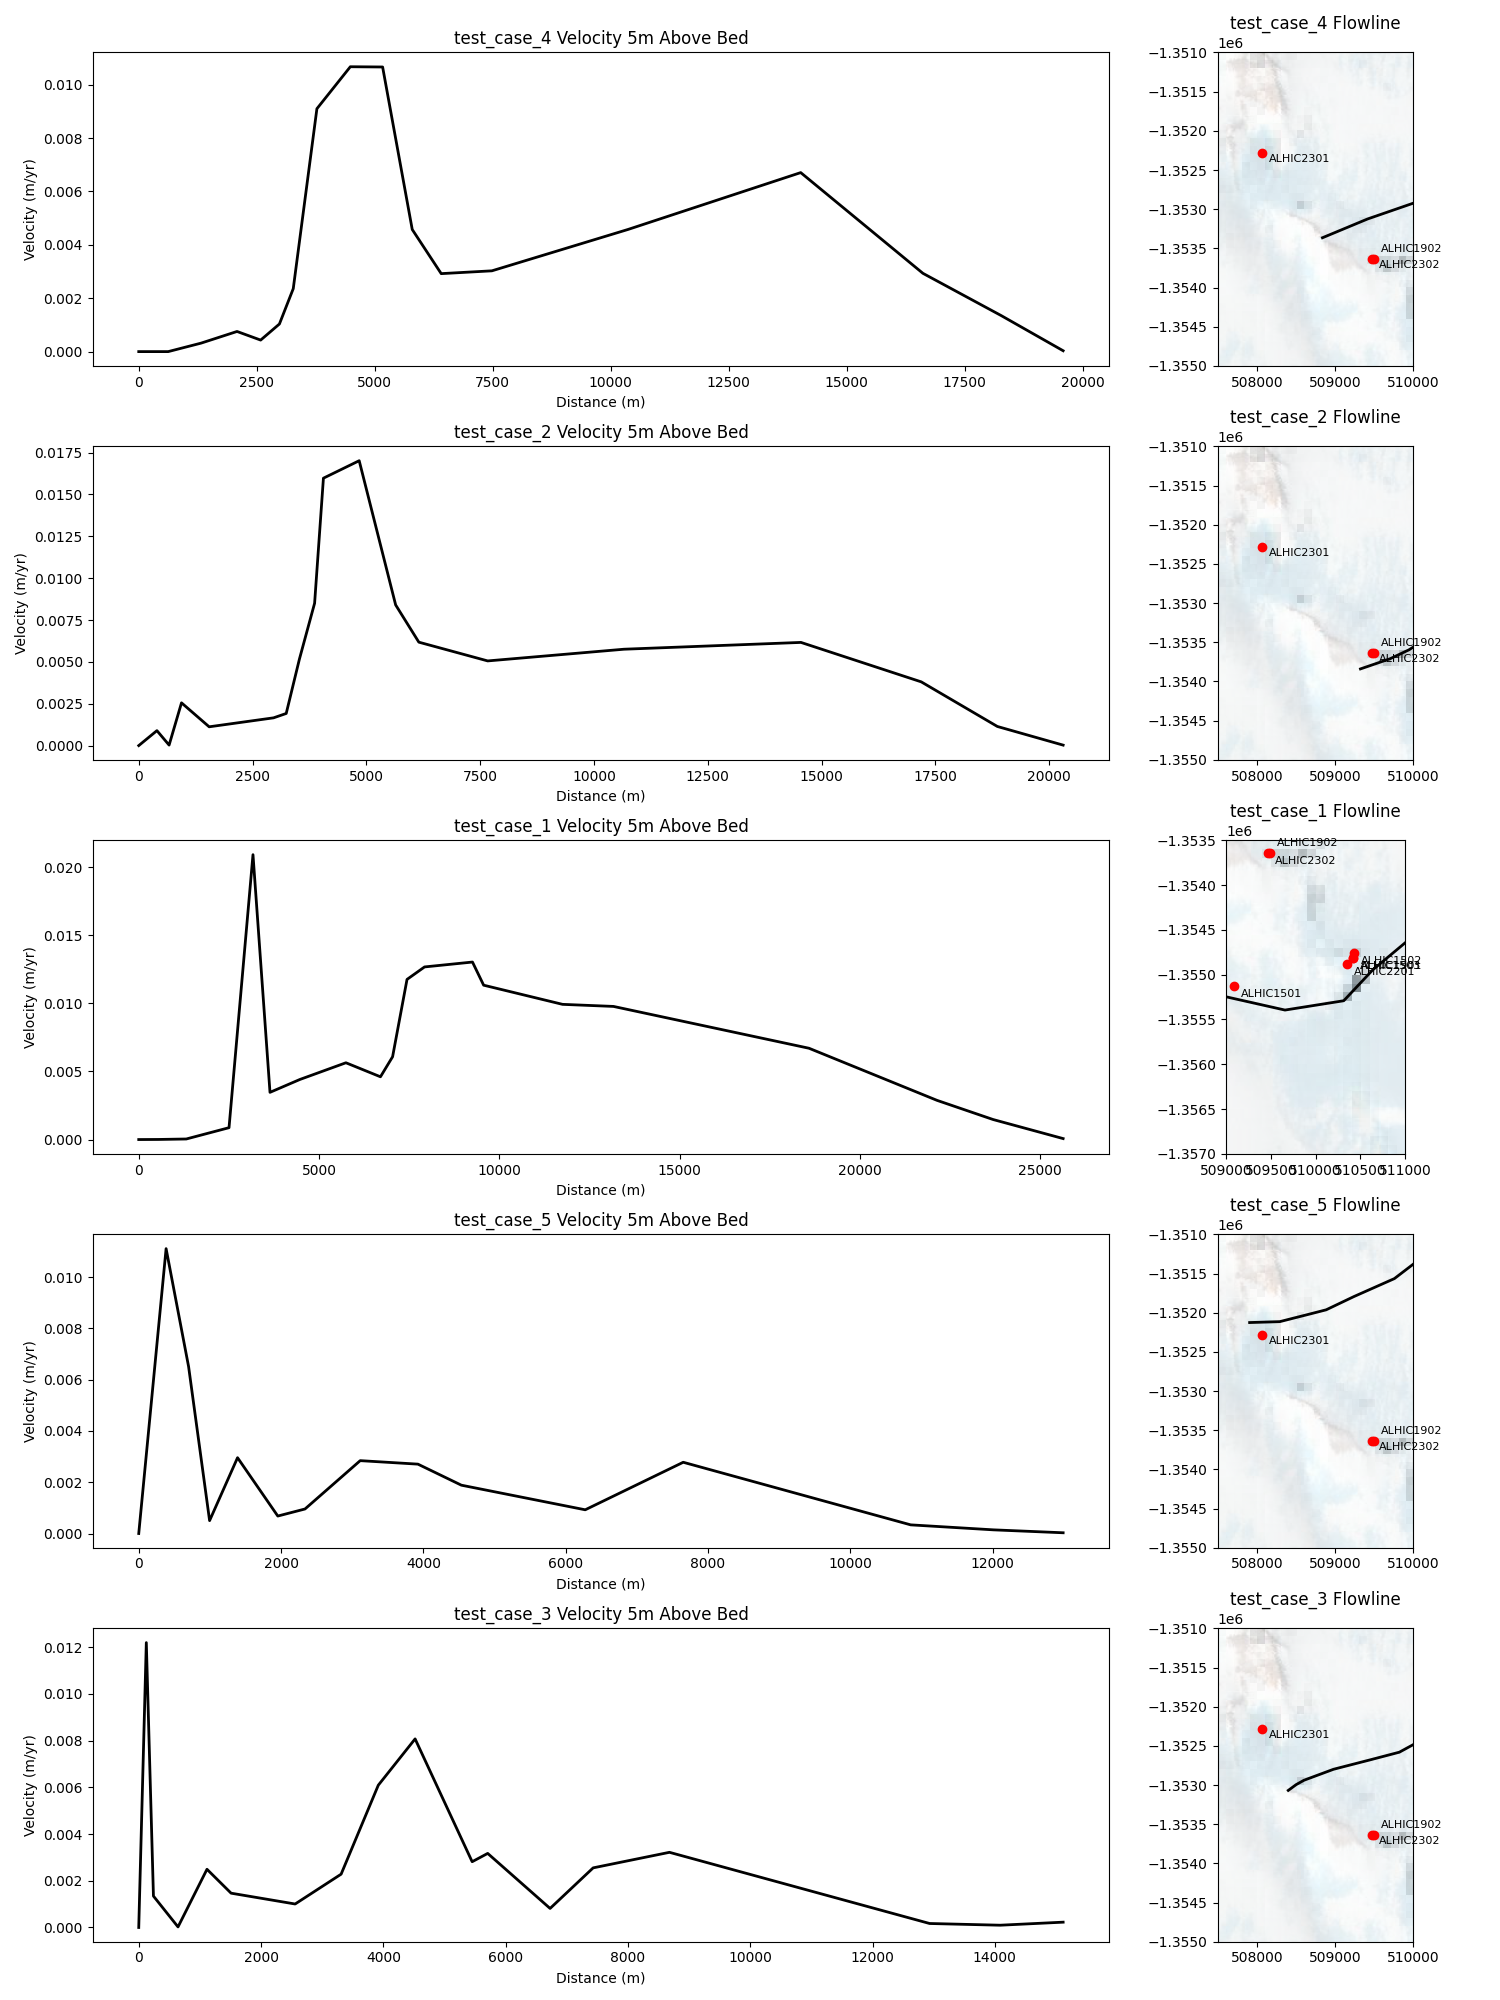

In [130]:
fig, axes = plt.subplots(len(velocity_near_bed), 2, figsize = [15,20], width_ratios=[3, 1])

for i, ax in zip(velocity_near_bed, axes):
    

    x_coord, vel_near_bed = velocity_near_bed[i]

    ax[0]. plot(x_coord, vel_near_bed, color='black', linewidth=2)
    ax[0].set_ylabel('Velocity (m/yr)')
    ax[0].set_xlabel('Distance (m)')
    ax[0].set_title(i + ' Velocity 5m Above Bed')



    ## LIMA basemap image
    show(image_data, transform=src1.transform, ax=ax[1])
    show(old_ice_loc_data, transform=src_old_ice.transform, ax=ax[1], alpha = 0.8, cmap="Greys")

    ax[1].plot(flowlines[i][0], flowlines[i][1], color='black', linewidth=2)
    ax[1].set_title(i + ' Flowline')

    ## Borehole locations
    for shape, record in zip(bor_shapes,bor_records):
        points = shape.points
        x, y = zip(*points)

        ax[1].plot(x, y, 'o',color='red', markersize=6)
        if record[0] == 'ALHIC1902':
            ax[1].annotate(record[0], xy=(x[0], y[0]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
        else:
            ax[1].annotate(record[0], xy=(x[0], y[0]-200), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
    if i == 'test_case_1':
        ax[1].set_xlim([509000, 511000])
        ax[1].set_ylim([-1.357e6, -1.3535e6])
    else:
        ax[1].set_xlim([507500, 510000])
        ax[1].set_ylim([-1.355e6, -1.351e6])
    print(i)
plt.tight_layout()
plt.savefig('old_ice_flowlines_vel_5m_above_bed.png', dpi=300)

### 8.2 Plot again but with a line colored by speed

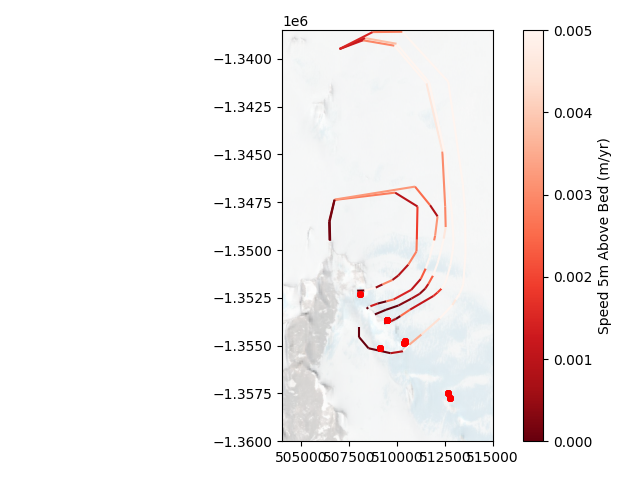

In [184]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots()

for i in velocity_near_bed:

    ## LIMA basemap image
    show(image_data, transform=src1.transform, ax=ax)
    show(old_ice_loc_data, transform=src_old_ice.transform, ax=ax, alpha = 0.8, cmap="Greys")

    x_coord, vel_near_bed = velocity_near_bed[i]
    x, y = flowlines[i][0], flowlines[i][1]
    points = np.vstack((x, y)).T.reshape(-1, 1, 2)
    segments = np.hstack((points[:-1], points[1:]))

    norm = plt.Normalize(0, 0.5e-2)
    cmap = plt.get_cmap('Reds_r')
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(vel_near_bed)

    lc = LineCollection(segments, array=vel_near_bed,cmap=cmap, norm=norm)
    line = ax.add_collection(lc)


    ## Borehole locations
    for shape, record in zip(bor_shapes,bor_records):
        points = shape.points
        x, y = zip(*points)

        ax.plot(x, y, 'o',color='red', markersize=4)
        # if record[0] == 'ALHIC1902':
        #     ax.annotate(record[0], xy=(x[0], y[0]), xytext=(-50, 5), textcoords='offset points', fontsize=8, color='black')
        # else:
        #     ax.annotate(record[0], xy=(x[0], y[0]-200), xytext=(-50, 5), textcoords='offset points', fontsize=8, color='black')
    
    ### Zoomed in version ###
    # if i == 'test_case_1':
    #     ax.set_xlim([509000, 511000])
    #     ax.set_ylim([-1.357e6, -1.3535e6])
    # else:
    #     ax.set_xlim([507500, 510000])
    #     ax.set_ylim([-1.355e6, -1.351e6])
    ### Not zoommed in version ###
ax.set_xlim([504000, 515000])
ax.set_ylim([-1.36e6, -1.3385e6])   

fig.colorbar(mappable, ax=ax, label = "Speed 5m Above Bed (m/yr)")

plt.savefig('old_ice_flowlines_vel_5m_above_bed_map_1fig.png', dpi=300)
plt.tight_layout()
plt.show()

